<a href="https://colab.research.google.com/github/hobibilgisi/Netkent/blob/main/MNIST_Data_Seti_%C4%B0le_Aktivasyon_Fonksiyonlar%C4%B1na_Verimlilik_Testi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MNIST data seti üzerinde en sık kullanılan aktivasyon fonksiyonlarının ayrı ayrı çalıştırılarak sonçlarının karşılaştırılması.

- Sigmoid Fonksiyonu
- Hiperbolik Tanjant
- ReLU Fonksiyonu
- Leaky-ReLU Fonksiyonu
- Swish Fonksiyonu


Kimlik doğrulama

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


işlemler Tesla T4 GPU kullanılarak yapılacaktır.

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12473701605141873874
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14357954560
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17054465526966817869
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

Keras kütüphanesinin kurulumu.

In [5]:
!pip install -q keras

Keras kütüphanesine gömülü olan MNIST el yazısı tanıma veri setinin yüklenmesi işlemi.

Modellerin ve katmanların import edilmesi.

Görselleştirme için matplot kütüphanesinin import edilmesi.

In [6]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from tensorflow.python.keras import regularizers

import tensorflow  as tf
from keras.layers import *
from keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt

Google apis veri tabanından MNIST veri setinin indirilmesi.

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


MNIST veri setinde bulunun etiketlenmiş eğitim verilerinden 25x25 boyutlarında 40 adet öğenin 10x8 boyutunda bir alanda gösterilmesi.

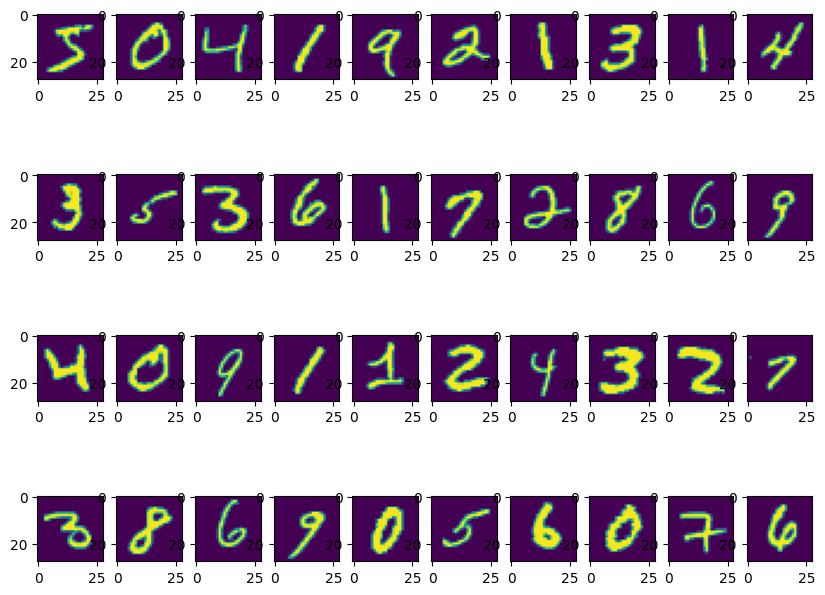

In [8]:
plt.figure(figsize=(10,8))
x, y = 10, 4
for i in range(40):
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i])
plt.show()

YApılandırma Ayarları
- Küme boyutu,
- sınıf sayısı,
- iterasyon sayısı
- başlangıç değerinin belirlenmesi.

In [9]:
batch_size = 128 # Küme Boyutu
num_classes = 10 # Sınıf Sayısı
epochs = 20 # Eğitimin epoch sayısı
w_l2 = 1e-5 # Başlangıç

Modelin gelişmesi durduğunda öğrenme oranını azaltarak işlemin tamamlanması sağlanır. Bu kapsamda;

- monitor: İzlenecek miktar,
- factor: öğrenme oranının azaltılacağı faktör,
- patience: hiçbir ilerlemenin olmadığı dönem sayısı. sonrasında öğrenme oranı düşecek.
- min_lr: öğrenme oranının alt sınırı.

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

28x28 ölçülerinde giriş görüntülerini kullandığımız eğitim verilerini ikiye ayırmış durumdayız.
x_train yani giriş eğitim verileri 60.000 adet örneğe sahipken x_test yahi giriş test verilerinin sayısı 10.000 adettir.
giriş verilerimiz tek renkli olduğu için tek kanallı olarak kullanılmıştır.

In [11]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# sınıf vektörlerini ikili sınıf matrislerine dönüştürmek
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Evrişimli Sinir Ağını (CNN) eğitiyoruz ve aktivasyon fonksiyonu olarak
-	Sigmoid,
-	Hiperbolik Tanjant
-	Relu Fonksiyonu
-	Leaky-Relu Fonksiyonu
-	Swish fonksiyonu
fonksiyonlarını ayrı ayrı uyguluyoruz.


Keras kullanarak bir evrişimli sinir ağı (Convolutional Neural Network - CNN) modeli oluşturulur. Kod bloğunda bulunan satırlar aşağıda açıklanmıştır.:

***model = Sequential():*** Boş bir Sequential modeli oluşturulur. Bu model, katmanları sırasıyla eklemek için kullanılır.

***model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(w_l2), input_shape=input_shape)):*** İlk evrişim katmanı eklenir. Bu katman, 32 filtre kullanır, her biri 3x3 boyutundadır. kernel_regularizer parametresi, L2 düzenleme (weight regularization) uygulamak için kullanılır ve w_l2 ile belirtilen düzenleme terimi eklenir. input_shape parametresi, modelin girdi verilerinin boyutunu belirtir.

***model.add(BatchNormalization()):*** Evrişim katmanının çıkışları için toplu normalleştirmeyi uygular.

***model.add(Activation('sigmoid')):*** Evrişim katmanının çıkışlarına sigmoid aktivasyon fonksiyonunu uygular.

***model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(w_l2))):*** İkinci bir evrişim katmanı eklenir. Bu katman 64 filtre kullanır ve her biri 3x3 boyutundadır. L2 düzenlemesi uygulanır.

***model.add(BatchNormalization()):*** İkinci evrişim katmanının çıkışları için toplu normalleştirmeyi uygular.

***model.add(Activation('sigmoid')):*** İkinci evrişim katmanının çıkışlarına sigmoid aktivasyon fonksiyonunu uygular.

***model.add(MaxPooling2D(pool_size=(2, 2))):*** Maksimum havuzlama (max pooling) katmanı eklenir. Bu, veri boyutunu küçültmek ve önemli özellikleri vurgulamak için kullanılır.

***model.add(Dropout(0.25)):*** Dropout katmanı eklenir. Bu, aşırı uyumu azaltmak için kullanılır ve %25 lik kısmını devre dışı bırakır.

***model.add(Flatten()):*** Düzleştirme katmanı eklenir. Bu, evrişim ve havuzlama katmanlarının çıkışlarını düz bir vektöre dönüştürür.

***model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2))):*** Tam bağlantılı (fully connected) bir katman eklenir. Bu katmanda 128 nöron içerir ve L2 düzenlemesi uygulanır.

***model.add(BatchNormalization()):*** normalleştirmeyi uygular.

***model.add(Activation('sigmoid')):*** katmanın çıkışlarına sigmoid aktivasyon fonksiyonunu uygular.

***model.add(Dropout(0.5)):*** Bir başka Dropout katmanı eklenir.

***model.add(Dense(num_classes, activation='softmax')):*** Çıkış katmanı eklenir ve softmax aktivasyon fonksiyonu ile sınıf olasılıklarını üretir.

***model.compile(...):*** Modelin derlenmesi işlemi gerçekleştirilir. Kayıp fonksiyonu, optimizer ve metrikler belirtilir.

***model.summary():*** Modelin özetini yazdırır, bu özetde katmanlar, parametre sayıları ve çıkış boyutları görüntülenir.

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 24, 24, 64)        0

sigmoid fonksiyon ile model eğitimi.

In [13]:
hist_sigmoid=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 [==============================] - 26s 14ms/step - loss: 0.5532 - accuracy: 0.8634 - val_loss: 0.3290 - val_accuracy: 0.9304 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 6s 13ms/step - loss: 0.2027 - accuracy: 0.9502 - val_loss: 0.1059 - val_accuracy: 0.9728 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 6s 13ms/step - loss: 0.1444 - accuracy: 0.9626 - val_loss: 0.1326 - val_accuracy: 0.9643 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 8s 17ms/step - loss: 0.1217 - accuracy: 0.9690 - val_loss: 0.0730 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 6s 13ms/step - loss: 0.1062 - accuracy: 0.9738 - val_loss: 0.0794 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0983 - accuracy: 0.9755 - val_loss: 0.0996 - val_accuracy: 0.9716 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 6s 13ms/s

HİPERBOLİK TANJANT AKTİVASYON FONKSİYONUNUN KULLANIMI

In [14]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_3 (Bat  (None, 26, 26, 32)        128       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 24, 24, 64)        256       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 24, 24, 64)       

Hiperbolik Tanjant Aktivasyon Formasyonu ile Eğitim

In [15]:
hist_tanh=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 [==============================] - 9s 14ms/step - loss: 0.1856 - accuracy: 0.9464 - val_loss: 0.0775 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0813 - accuracy: 0.9778 - val_loss: 0.0598 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0694 - accuracy: 0.9812 - val_loss: 0.0696 - val_accuracy: 0.9801 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0617 - accuracy: 0.9836 - val_loss: 0.0802 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0574 - accuracy: 0.9855 - val_loss: 0.0512 - val_accuracy: 0.9873 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0526 - accuracy: 0.9868 - val_loss: 0.0531 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 6s 13ms/st

RELU AKTİVASYON FONKSİYONUNUN KULLANIMI

In [16]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_6 (Bat  (None, 26, 26, 32)        128       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 24, 24, 64)        256       
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 24, 24, 64)       

RELU AKTİVASYON FONKSİYONU İLE EĞİTİM

In [17]:
hist_relu=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 [==============================] - 9s 13ms/step - loss: 0.1855 - accuracy: 0.9491 - val_loss: 0.2752 - val_accuracy: 0.9205 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0787 - accuracy: 0.9783 - val_loss: 0.0501 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0644 - accuracy: 0.9836 - val_loss: 0.0464 - val_accuracy: 0.9876 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0574 - accuracy: 0.9856 - val_loss: 0.0427 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0525 - accuracy: 0.9869 - val_loss: 0.0442 - val_accuracy: 0.9890 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 6s 13ms/step - loss: 0.0477 - accuracy: 0.9890 - val_loss: 0.0452 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 6s 13ms/st

Leaky (Sızıntı) ReLU Fonksiyonu

Bu fonksiyon keras içinde advanced activation function olarak tanımlıdır bu yüzen bu fonksiyonu import edip model içinde kullanmamız gerekir.

In [18]:
from keras.layers import LeakyReLU

In [19]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=.001))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=.001))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_9 (Bat  (None, 26, 26, 32)        128       
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 26, 26, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_10 (Ba  (None, 24, 24, 64)        256       
 tchNormalization)                                               
                                                                 
 dense_6 (Dense)             (None, 24, 24, 64)       

Leaky (Sızıntı) ReLU Fonksiyonu İLE EĞİTİM

In [20]:
hist_LeakyReLU=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 [==============================] - 11s 16ms/step - loss: 0.1791 - accuracy: 0.9477 - val_loss: 0.1797 - val_accuracy: 0.9481 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 7s 16ms/step - loss: 0.0806 - accuracy: 0.9777 - val_loss: 0.0426 - val_accuracy: 0.9882 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 7s 16ms/step - loss: 0.0664 - accuracy: 0.9815 - val_loss: 0.0441 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0588 - accuracy: 0.9841 - val_loss: 0.0590 - val_accuracy: 0.9826 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 7s 16ms/step - loss: 0.0544 - accuracy: 0.9859 - val_loss: 0.0501 - val_accuracy: 0.9868 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0502 - accuracy: 0.9876 - val_loss: 0.0468 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 7s 16ms/s

Swish Aktivasyon Fonksiyonunun Tanımlanması

In [21]:
def swish(x):
    return x * K.sigmoid(x)
    # return x * (1/(1 + K.exp(-x)))

In [22]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(w_l2), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation(swish))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_12 (Ba  (None, 26, 26, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_9 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_13 (Ba  (None, 24, 24, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_10 (Activation)  (None, 24, 24, 64)       

Swish Aktivasyon Fonksiyonu İLE EĞİTİM

In [23]:
hist_swish=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 [==============================] - 11s 18ms/step - loss: 0.1577 - accuracy: 0.9572 - val_loss: 0.0488 - val_accuracy: 0.9859 - lr: 0.0010
Epoch 2/20
469/469 [==============================] - 7s 16ms/step - loss: 0.0698 - accuracy: 0.9825 - val_loss: 0.0481 - val_accuracy: 0.9872 - lr: 0.0010
Epoch 3/20
469/469 [==============================] - 8s 17ms/step - loss: 0.0555 - accuracy: 0.9867 - val_loss: 0.0395 - val_accuracy: 0.9903 - lr: 0.0010
Epoch 4/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0473 - accuracy: 0.9884 - val_loss: 0.0390 - val_accuracy: 0.9916 - lr: 0.0010
Epoch 5/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0434 - accuracy: 0.9904 - val_loss: 0.0399 - val_accuracy: 0.9919 - lr: 0.0010
Epoch 6/20
469/469 [==============================] - 8s 16ms/step - loss: 0.0417 - accuracy: 0.9913 - val_loss: 0.0441 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 7/20
469/469 [==============================] - 8s 17ms/s

Kaydedilen sonuçların çizilmesi için plot fonksiyonunun tanımlanması

In [24]:
def plot_history(hists, attribute='val_loss', axis=(-1,21,0.85,0.94), loc='lower right'):
    ylabel = {'oss': 'loss', 'acy': 'accuracy'}
    title = {'val_loss': 'valid. loss', 'loss': 'trn. loss', 'val_accuracy': 'valid. accuracy', 'accuracy': 'trn. accuracy'}
    num_hists = len(hists)

    plt.figure(figsize=(12, 8))
    plt.axis(axis)
    for i in range(num_hists):
        plt.plot(hists[i].history[attribute])
    plt.title(title[attribute])
    plt.ylabel(ylabel[attribute[-3:]])
    plt.xlabel('epoch')
    plt.legend(['Sigmoid', 'tanh', 'ReLU', 'Leaky_ReLU', 'Swish'], loc=loc)

    plt.show()

In [25]:
hists = [hist_sigmoid, hist_tanh, hist_relu, hist_LeakyReLU, hist_swish]

***plot_history:*** Bu işlev tarihçe verilerini çizmek ve görselleştirmek için kullanılır.

***hists:*** grafik üzerinde çizilecek tarihçe verilerini içeren bir listeyi temsil eder.

***attribute='val_accuracy':*** Bu, grafiğin hangi özelliği çizeceğini belirtir. "val_accuracy" doğrulama doğruluğunu/performansı (validation accuracy) temsil eder. Grafik, eğitim süreci boyunca doğrulama doğruluğunun nasıl değiştiğini gösterir.

***axis=(-1,21,0.95,0.9960):*** Grafik eksenlerinin sınırlarını belirtir.  x-ekseni (-1 ile 21 arasında) ve y-ekseni (0.95 ile 0.9960 arasında) sınırları verilmiştir. Bu, grafikte hangi aralıkların gösterileceğini belirler.

***loc='lower right':*** Bu, grafik üzerinde bir yerleşim (location) konumunu belirtir. "lower right"  grafiğin sağ alt köşesindeki bir konumu ifade eder.

SONUÇLARIN KARŞILAŞTIRILMASI

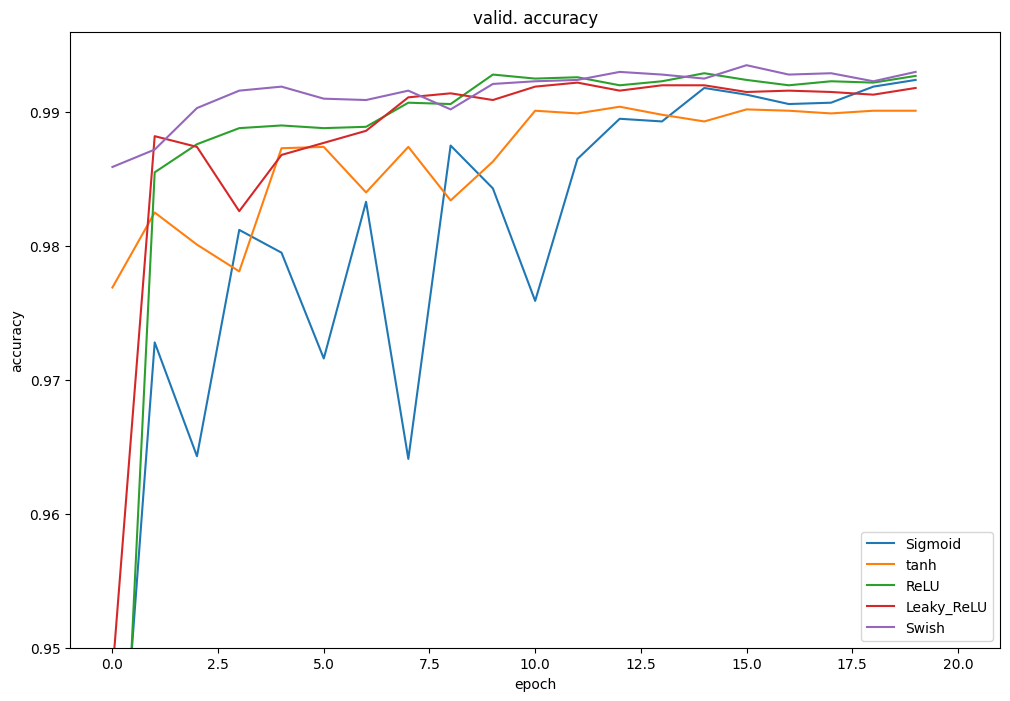

In [26]:
plot_history(hists, attribute='val_accuracy',axis=(-1,21,0.95,0.9960), loc='lower right')

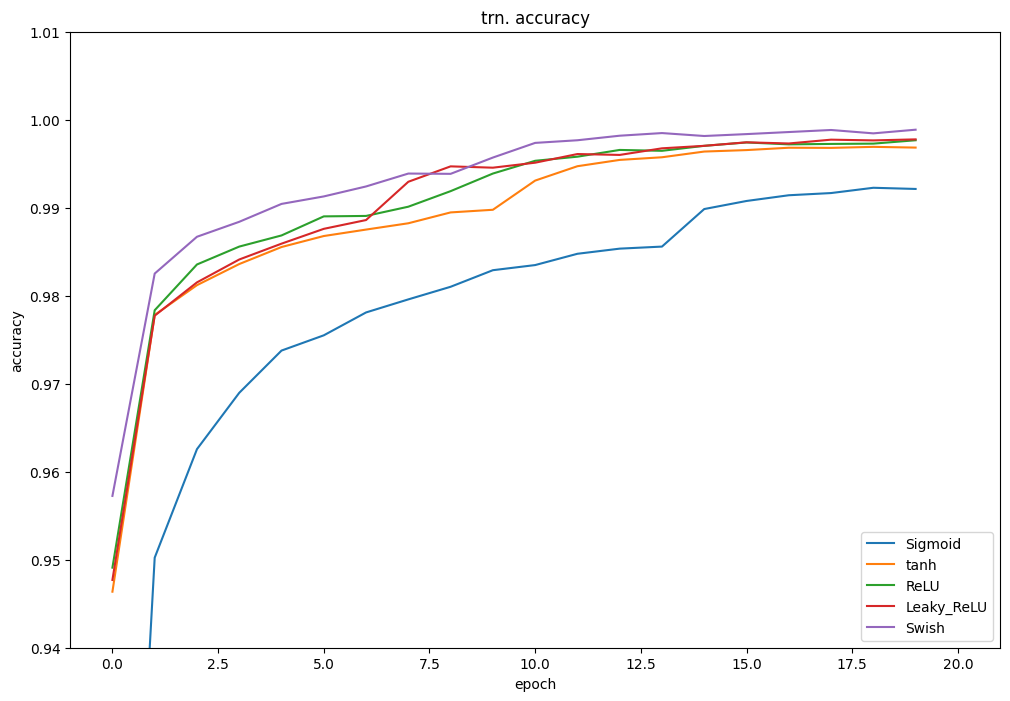

In [27]:
plot_history(hists, attribute='accuracy', axis=(-1,21,0.94,1.01), loc='lower right')

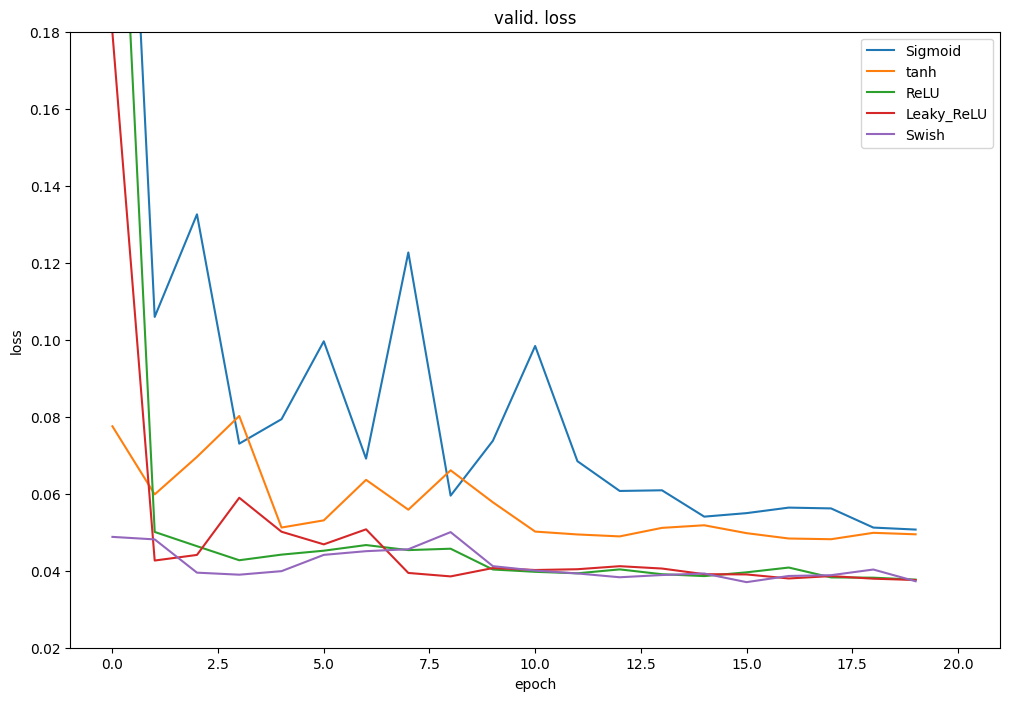

In [28]:
plot_history(hists, attribute='val_loss', axis=(-1,21,0.02,0.18), loc='upper right')

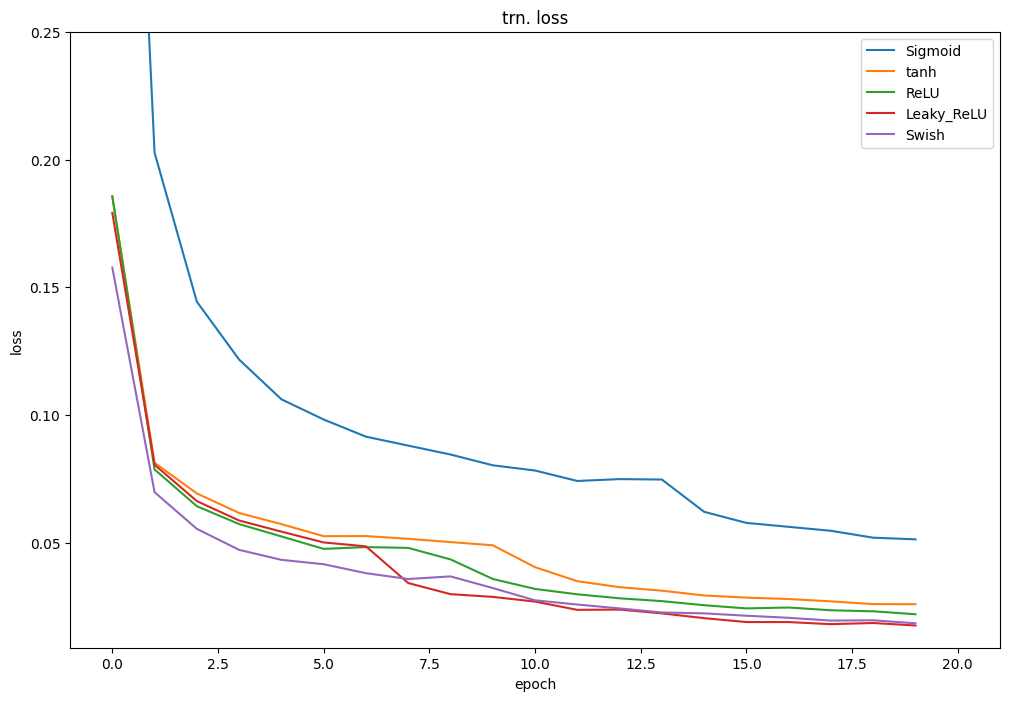

In [29]:
plot_history(hists, attribute='loss', axis=(-1,21,0.009,0.25), loc='upper right')